In [1]:
import pygad 
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal, skew
import pygad
import matplotlib.pyplot as plt


In [104]:
def expected_returns(period):
    return pd.Series({
		'ACWI': 0.07/period,
		'^TBSP': 0.035/period,
		'XAUPLN': 0.05/period,
		'MWIG40': 0.065/period,
		'IHYU.L': 0.038/period,
		'PLOPLN3M': 0.03/period,
		'edo': 0.04/period
})

cov = np.array([[0.001265,	0.000042],
            	[0.000042,	0.000164]])
cov_y = cov * 12

In [105]:
assets = ['ACWI', '^TBSP']
means = expected_returns(1)[assets]
number_of_scenarios = 601
T = 20
sim_returns = []

for s in range (number_of_scenarios):
    sim_returns.append(multivariate_normal.rvs(means,cov_y, T))

sim_returns = np.array(sim_returns)
sim_returns.shape

(601, 20, 2)

In [106]:
means = sim_returns.mean(1)

result = pd.DataFrame({},index=['mean','0.25','0.5','0.75'])
result.loc['mean','mean'] = means[0].mean()
result.loc['mean','mean_ann'] = means[0].mean() *12
result.loc['mean','std'] = means[0].std()
result.loc['mean','skewsness'] = skew(means[0])

sorted = np.sort(means,0)
result.loc['0.25','mean'] = sorted[len(means)//4*1].mean()
result.loc['0.25','mean_ann'] = sorted[len(means)//4*1].mean() *12
result.loc['0.25','std'] = sorted[len(means)//4*1].std() 
result.loc['0.75','mean'] = sorted[len(means)//4*3].mean()
result.loc['0.75','mean_ann'] = sorted[len(means)//4*3].mean() *12
result.loc['0.75','std'] = sorted[len(means)//4*3].std() 
result


,mean,mean_ann,std,skewsness
mean,0.044645,0.535740,0.010345,1.051925e-15
0.25,0.040317,0.483798,0.011917,NaN
0.5,NaN,NaN,NaN,NaN
0.75,0.066343,0.796113,0.024191,NaN


In [107]:
def fanchart(hist,percentiles):
    length = 19
    x = np.linspace(0,length+1,length+1)
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[4], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[3], color='blue', alpha=0.2)
    ax.plot(percentiles[2],color='blue')

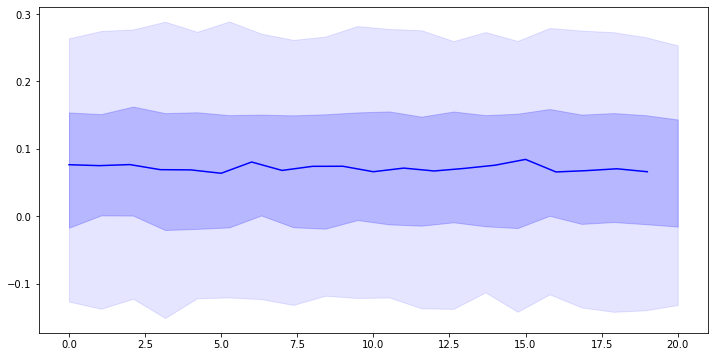

In [108]:
perc = np.percentile(sim_returns[:,:,0],[5,25,50,75,95],axis=0)
fanchart(None,perc)

In [109]:
class Simulation():
    def __init__(self, initial_value, inflows, returns, strategy) -> None:
        self.capital = initial_value
        self.returns = returns
        self.strategy = strategy 
        self.inflows = inflows
    
   
    def step(self, current_value,inflow,weights,returns):
        current_assets_value = np.expand_dims(current_value,axis=0).T * weights
        next_assets_value =  np.round(current_assets_value * (1+returns),2)
        return next_assets_value.sum(1)
    
        
    def run(self, T):
        for t in range(T):
            self.capital = self.step(self.capital,self.inflows[t],self.strategy[t],self.returns[:,t])


In [110]:
portfolios = [[0.0,1.0],
             [0.1,0.9],
             [0.2,0.8],
             [0.3,0.7],
             [0.4,0.6],
             [0.5,0.5],
             [0.6,0.4],
             [0.7,0.3],
             [0.8,0.2],
             [0.9,0.1],
             [1.0,0.0]]

In [135]:
T = 20
capital = np.full(number_of_scenarios,100)
inflows = np.full(T,0)

l = np.arange(T,0,-1)
risk = 30

glide_paths = {}

for t in l:
    perc = []
    for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))
    glide_paths[t] = np.argmax(perc)

In [134]:
glide = list(glide_paths.values())
glide

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 9, 8, 10, 7, 5, 3]

In [133]:
T=4
risk = 30
perc = []
for portfolio in range(len(portfolios)):
        solution = np.full(T,portfolio)
        strategy = np.take(portfolios,solution, axis=0)
        simulator = Simulation(capital,inflows, sim_returns,strategy)
        simulator.run(t)
        perc.append(np.percentile(simulator.capital,risk))

In [374]:
simulator = Simulation(100,np.full(T,0), sim_returns,glide)
simulator.run(T)
#np.percentile(simulator.capital,risk)
end_capital = simulator.capital

In [111]:
r = 0.3
T = 20
def fitness(ga_instance, solution, solution_idx):
    weights = np.take(portfolios, solution,axis=0)
    portfolio_sim = Simulation(100,np.full(T,0),sim_returns, weights)
    portfolio_sim.run(T)
    return np.quantile(portfolio_sim.capital,r)
    

In [116]:
solution = np.full(T,9)
fitness(None,solution,0)

253.85999999999999

- 2,0.1 - 113
- 8, 0.1 - 100
- 8, 0.4 - 125
- 2, 0.4 - 126

In [117]:
def initial_population(T,number_porfolios,solutions):
    population = np.zeros((solutions,T))
    population[:,0] = np.random.randint(0,number_porfolios+1, solutions)
    for t in range(1,T):
        population[:,t] = np.random.randint(0,population[:,t-1]+1, solutions) 
    return population

In [118]:
def isDescending(arr):
    diff = np.diff(arr)
    return np.all(diff <= 0)

def m_crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        random_split_point = np.random.choice(range(1,offspring_size[1]))

        result = parent1.copy()
        result[random_split_point:] = parent2[random_split_point:]
        if isDescending(result) != True:
            result = parent2.copy()
            result[random_split_point:] = parent1[random_split_point:]
           
        offspring.append(result)      

        idx += 1

    return np.array(offspring)

In [119]:
T = 20
initial_pop = initial_population(T,10,100)

In [120]:
sol_per_pop = 100
num_genes = T
num_parents_mating = 10
keep_parents = 2
gene_type= int
gen_space = [0,1,2,3,4,5,6,7,8,9,10]
parent_selection_type = 'tournament'
crossover_type = "single_point"
num_generations= 200
fitness_function = fitness
mutation_type = "random"
mutation_percent_genes = 10
random_mutation_min_val=-2.0
random_mutation_max_val=2.0
mutation_probability=0.4
crossover_probability=0.4
crossover_func=m_crossover_func

In [124]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       #sol_per_pop=sol_per_pop,
                       initial_population = initial_pop,
                       #num_genes=num_genes,
                       gene_type=gene_type,
                       gene_space=gen_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       #crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       random_mutation_min_val=random_mutation_min_val,
                       random_mutation_max_val=random_mutation_max_val,
                       mutation_probability=mutation_probability,
                       crossover_probability=crossover_probability,
                       crossover_type=crossover_func)

In [125]:
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()

In [126]:
print(solution)
print(solution_fitness)

[10  7 10  7  9 10  6 10 10  7  9  9  6  9  8  5  7  3  9  6]
256.2


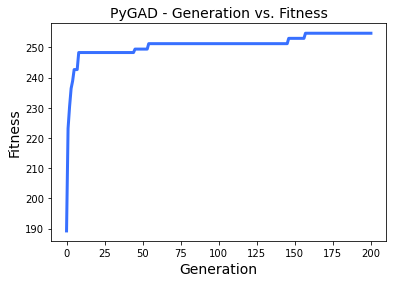

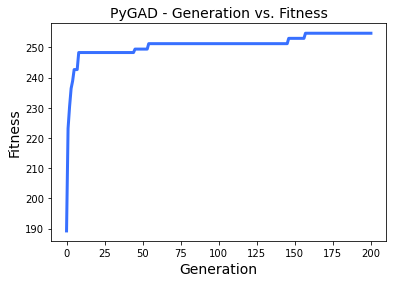

In [393]:
ga_instance.plot_fitness()

[ 0  0  0  7  3  0  8  6  0  5  4  2  8  4  1 10  6  8  9  3  9 10  8  9
  9  3  4  7  1  5  3  3  7  5  1 10 10  9  8  4  4  4  5  9  7  6  5  5
  6  8  5  1  3  9  2  4  5  2  0  7]
129.62

In [394]:
fitness(None,glide,0)


240.7

In [62]:
def isDescending(arr):
    diff = np.diff(arr)
    return np.all(diff <= 0)

arr = [3,3,2]
isDescending([4, 4, 3, 2, 1]) == True


True

In [69]:
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        random_split_point = np.random.choice(range(1,offspring_size[1]))

        result = parent1.copy()
        result[random_split_point:] = parent2[random_split_point:]
        if isDescending(result) != True:
            result = parent2.copy()
            result[random_split_point:] = parent1[random_split_point:]
           
        offspring.append(result)      

        idx += 1

    return np.array(offspring)

In [98]:
from unittest.mock import patch

def mock_rand(range):
        return 0


parents = np.array([[4,3,3,2,2],
                     [7,6,5,2,1]])

result = None

""" with patch('numpy.random.choice',mock_rand):
    result = crossover_func(parents, (1,5), None) """

crossover_func(parents, (1,5), None)
#result

array([[7, 6, 5, 2, 1]])

In [84]:
arr = [4,3,3,3,3]
arr[:0]

[]